# <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Numerical simulation of ASTM D86 experiment</span>

<div style="display: flex; justify-content: center;">
    <img src="astm_d86.png" alt="Logo" style="width:600px; height:300px;"/>
</div>

### <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Moldeing Assupmtions</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
To simulate the ASTM-D86 problem, two main blocks are asuumed. the first one is the flask and the second one is the graduated cylinder. The <br> main idea to simulate the ASTM D86 expriment is that at each step the distillation process is equal to a flash vaporization with a very little amount of vapor.<br>
At the begining, it is assumed that the temperature starts rising from the bubble point of the mixture. At each step, the temperature is slightly higher than <br>  the bubble point of the mixture inside the flask, resulting in only a small amount of vapor being generated. The vapor is collected as small droplets of liquid <br> which leave the condenser.
A flash calculation is performed at each step using the Peng-Robinson equation of state, and the volume of the droplet leaving the <br>condenser is calculated using a bubble point calculation. For the next step, the temperature is increased slightly, and all calculations are repeated until reaching a<br> state at which only a small droplet of liquid is remained in the flask.
Additionally, some necessary physical properties were obtained from Aspen HYSYS and Aspen Plus. It is assumed that the container contains components belonging to the n-alkane class for n-paraffin, 2-methylalkanes for i-paraffin, n-alkylbenzenes for aromatic, and Alkylcyclopentanes for Naphtene.
</span>
<br><br>
<span style="font-family: 'Times New Roman'; font-size: 14px; font-weight: bold; color: red;">NOTE:</span> 
<span style="font-family: 'Times New Roman'; font-size: 16px;">
This sumulation takes around 15 minuted to complete. For checking the performance, please change the value of final volume of the liquid remained in the flask at the "Starting the simulation" section to a value higher than 0.1 (this value is asummed to be the volume of the last droplet of liquid in the flask).
</span><br><br>

### <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">References</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
[1] Thermodynamics of Phase and Reaction Equilibria - Ismail Tosun - $2^{nd}$ edition. <br>
[2] PVT and Phase Behaviour of Petrolium Resevoir Fluids - Ali Danesh. <br>
[3] Fundamentals of Multicomponent Distillation - Charles D.Holland. <br>
[4] The Isothermal Flash  Problem. Part II. Phase-Split  Calculation - Michael L. Michelsen.
</span><br><br>

### <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Import libraries</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Functions</span>

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">LU Decomposition Method</span>

### <span style="font-family: 'Times New Roman'; font-size: 18px;">These functions are used inside the Newton's method to solve the set of linear equations</span>

In [2]:
# LU decomposition
def lu_decomposition(matrix):
    """
    Perform LU decomposition of a square matrix.

    Parameters:
    a (numpy.ndarray) : The square matrix to be decomposed.

    Returns:
    numpy.ndarray, numpy.ndarray: The lower triangular matrix (l) and the upper triangular  matrix (u).

    Raises:
    ValueError: If the input matrix is not square.
    """
    # Check if the matrix is square
    n, m = matrix.shape
    if n != m:
        raise ValueError("The input matrix is not a square matrix")
        
    l = np.eye(n)
    u = np.zeros((n, n))

    for j in range(n):
        for i in range(j+1):
            temp_sum = 0
            for k in range(i):
                temp_sum += l[i, k] * u[k, j]
            u[i, j] = matrix[i, j] - temp_sum


        for i in range(j+1, n):
            temp_sum = 0
            for k in range(j):
                temp_sum += l[i, k] * u[k, j]
            l[i, j] = (matrix[i, j] - temp_sum) / u[j, j]
    return l, u

# lU Decomposition Solver
def lu_solver(a, b):
    """
    Solve linear systems (Ax = b) Using LU decomposition method.

    Parameters:
    a (numpy.ndarray): The coefficients matrix.
    b (numpy.ndarray): The Right Hand Side (RHS) vector
    
    Returns:
    numpy.ndarray: The solution vector (x).
    """
    n = a.shape[0]
    z = np.zeros(n)
    x = np.zeros(n)    # x: solution vector
    l, u = lu_decomposition(a)
    
    for j in range(n):
        temp_sum = 0
        for i in range(j):
            temp_sum += l[j, i] * z[i]
        z[j] = b[j] - temp_sum
        
    for i in range(n-1,-1, -1):
        temp_sum = 0
        for j in range(i+1, n):
            temp_sum += u[i, j] * x[j]
        x[i] = (z[i] - temp_sum) / u[i, i]
    return x

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Cubic Polynomial Roots</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function is used to calculate the roots of Peng-Robinson EoS and find $Z^{L}$ and $Z^{V}.$
</span>

In [3]:
def cubic_root(coeff):
    """
    Computes the roots of a cubic equation of the form ax^3 + bx^2 + cx + d = 0.

    Parameters:
    coeff (list or numpy.ndarray): A list or array of length 4 containing the coefficients of the equation in descending order of degree.

    Returns:
    x(numpy.ndarray): A 1D array of length 3 containing the roots of the equation. The roots may be real or complex.

    Raises:
    Exception: If coeff is not a list or array of length 4, or if the coefficient of x^3 is zero.
    """
    if len(coeff) != 4:
        raise ValueError(f"The input length is {len(coeff)}. it must be 4.")
        
    a, b, c, d = coeff[0], coeff[1], coeff[2], coeff[3]
    f = ((3 * c / a) - (b**2 / a**2)) / 3
    g = (2 * b**3 / a**3 - 9 * b * c / a**2 + 27 * d / a) / 27
    h = g**2 / 4 + f**3 / 27
    
    x = []
    if h <= 0 and f != 0 and g != 0:  ## All 3 Roots Are REAL ##

        i = ((g**2 / 4) - h)**0.5
        q = np.cbrt(i)
        k = np.arccos(-g / (2 * i))
        L = q*-1
        M = np.cos(k/3)
        N = (3**0.5) * np.sin(k / 3)
        P = -(b/(3*a))
        x.append(2*q * np.cos(k / 3) - b / (3 * a))
        x.append(L * (M + N) + P)
        x.append(L * (M - N) + P)

    elif h > 0 and f != 0 and g != 0:    ## Only ONE Root is REAL ##
        R = -(g / 2) + h**0.5
        S = np.cbrt(R)
        T = -(g / 2) - h**0.5
        U = np.cbrt(T)
        x.append((S + U) - (b / (3 * a)))
        x.append((-(S + U) / 2 - (b / (3 * a)) - (S - U) * (3)**0.5 / 2j))
        x.append((-(S + U) / 2 - (b / (3 * a)) + (S - U) * (3)**0.5 / 2j))

    elif f == 0 and g == 0 and h == 0:   ## All 3 Roots Are Real and EQUAL ##
        x.append(-(d / a)**(1 / 3))
        x.append(-(d / a)**(1 / 3))
        x.append(-(d / a)**(1 / 3))

    return np.array(x)

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Jacobian Matrix</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function is used to calculate the jacobian of equations inside the Newton's method to solve the set of nonlinear equations.
</span>

In [4]:
def jacobian_matrix(equations, evaluation_point, perturbation=1e-3):
    """
    Compute the Jacobian matrix of a system of equations at a specified evaluation point.

    Parameters:
    equations (function): A function that takes a vector and returns a vector of equations to solve.
    evaluation_point (numpy.ndarray): The point at which to evaluate the Jacobian matrix.
    perturbation (float, optional): The perturbation value used for finite differences (default: 1e-6).

    Returns:
    numpy.ndarray: The Jacobian matrix at the specified evaluation point.
    """
    # Find the shape of the Jacobian matrix
    n = evaluation_point.shape[0]
    jacobian = np.zeros((n, n))
    
    # Evaluate the equations at the specified point
    eq = equations(evaluation_point)
    
    # Claculate the elements of the Jacobian matrix
    for i in range(n):
        perturbed_point = evaluation_point.copy()
        perturbed_point[i] += perturbation * abs(evaluation_point[i]) if evaluation_point[i] != 0 else perturbation
        eq_perturbed = equations(perturbed_point)
        jacobian[:, i] = (eq_perturbed - eq) / (perturbed_point[i] - evaluation_point[i])

    return jacobian

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Newton's Method</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function solves the set of nonlinear equations.
</span>

<br>
<span style="font-family: 'Times New Roman'; font-size: 14px; font-weight: bold; color: red;">NOTE:</span> 
<span style="font-family: 'Times New Roman'; font-size: 14px;">
For this particular problem, Newton's method is faster without using Broyden and Householder methods. This may be because of small size of equations set (155 equations).
</span>

In [6]:
# Newton's method for nonlinear systems
def newton(equations, init_guess, tol=1e-8, max_iter=100, disp=False):
    """
    Solve a system of equations using the Newton-Raphson method.

    Parameters:
    -----------
    equations (callable) :A function that takes a numpy.ndarray as input and returns a numpy.ndarray representing
    the system of nonlinear equations to be solved. The input ndarray represents the current values
    of the variables.
    init_guess (numpy.ndarray) : The initial guess for the solution of the system of equations.
    tol (float, optional): The tolerance for convergence. The iteration will stop when the L2-norm of the system of equations
    is less than this value. Default is 1e-8.
    max_iter (int, optional): The maximum number of iterations. If the convergence criterion is not met within this number of 
    iterations, a ValueError will be raised. Default is 100.
    disp (Boolian, optional): print the 2-norm of the equations for each iteration. Default is False.
    
    Returns:
    --------
    numpy.ndarray
        The solution to the system of equations.

    Raises:
    -------
    ValueError
        If the maximum number of iterations is reached without meeting the convergence criterion.
    """
    x = init_guess.copy()
    f = equations(x)
    
    # Main loop
    for k in range(max_iter):
        norm_f = np.linalg.norm(f)
        
        # Display the results at each iteration 
        if disp:
            print(f"#{k}: norm = {norm_f :^30.10f}")
            
        # Check the convergence criteria
        if norm_f < tol:
            return x
        
        # Calculate new solution candidate
        jacobian = jacobian_matrix(x, equations)
        delta_x = lu_solver(jacobian, -f)
        x += delta_x
        f = equations(x)
    
    raise ValueError("Could not converge. Try new initial guess or increase the maximum number of iterations.")

In [7]:
def newton_householder(equations, init_guess, tol=1e-8, max_iter=100, disp=False):
    """
    Solve a system of nonlinear equations using the Householder method.

    Parameters:
    -----------
    equations (callable) :A function that takes a numpy.ndarray as input and returns a numpy.ndarray representing
    the system of nonlinear equations to be solved. The input ndarray represents the current values
    of the variables.
    init_guess (numpy.ndarray) : The initial guess for the solution of the system of equations.
    tol (float, optional): The tolerance for convergence. The iteration will stop when the L2-norm of the system of equations
    is less than this value. Default is 1e-8.
    max_iter (int, optional): The maximum number of iterations. If the convergence criterion is not met within this number of 
    iterations, a ValueError will be raised. Default is 100.
    disp (Boolian, optional): print the 2-norm of the equations for each iteration. Default is False.

    Returns:
    --------
    numpy.ndarray: The solution to the system of nonlinear equations.

    Raises:
    -------
    ValueError: If the maximum number of iterations is reached without meeting the convergence criterion.
    """
    
    x = init_guess.copy()
    f = equations(x)
    
    # Main loop
    for k in range(max_iter):
        norm_f = norm2(f)
        
        # Display the results at each iteration 
        if disp:
            print(f"#{k}: norm(f) = {norm_f}")
        
        # Check the convergence criteria
        if norm_f < tol:
            return x
        
        # Householder method
        s = 1.0
        l = 0
        for j in range(max_iter):
            if l > 2 or k == 0:
                jacobian = jacobian_matrix(equations, x)
                H = -inverse_matrix(jacobian)
                delta_x = s * H @ f
                s = 1.0
                l = 0
            
            # Evaluate F(x)
            F = equations(x + delta_x)

            # Check the convergence condition
            if norm2(F) <= norm_f:
                x_ = x + s * delta_x
                f_ = equations(x_)
                y = (f_ - f).T

                H -= ((H @ y + s * delta_x) @ (delta_x @ H)) / (delta_x @ H @ y)
                x = x_
                f = equations(x)
                s = 1.0
                l = 0
                break
            
            # Calculate new step size
            #eta = (F @ F) / (f @ f)
            #s = ((1 + 6 * eta)**0.5 - 1) / (3 * eta)
            s *= 0.7
            l += 1
    else:
        raise ValueError("Could not converge. Try a new initial guess or increase the maximum number of iterations.")

In [8]:
def newton_broyden(equations, init_guess, tol=1e-8, max_iter=100, disp=False):
    """
    Solve a system of nonlinear equations using the Broyden's method.

    Parameters:
    -----------
    equations (callable) :A function that takes a numpy.ndarray as input and returns a numpy.ndarray representing
    the system of nonlinear equations to be solved. The input ndarray represents the current values
    of the variables.
    init_guess (numpy.ndarray) : The initial guess for the solution of the system of equations.
    tol (float, optional): The tolerance for convergence. The iteration will stop when the L2-norm of the system of equations
    is less than this value. Default is 1e-8.
    max_iter (int, optional): The maximum number of iterations. If the convergence criterion is not met within this number of 
    iterations, a ValueError will be raised. Default is 100.
    disp (Boolian, optional): print the 2-norm of the equations for each iteration. Default is False.

    Returns:
    --------
    numpy.ndarray: The solution to the system of nonlinear equations.

    Raises:
    -------
    ValueError: If the maximum number of iterations is reached without meeting the convergence criterion.
    """
    x = init_guess.copy()
    f = equations(x)
    
    # Main loop
    for k in range(max_iter):
        norm_f = norm2(f)
        
        # Display the results at each iteration 
        if disp:
            print(f"#{k}: norm = {norm_f :^30.10f}")
        
        # Check the convergence criteria
        if norm_f < tol:
            return x
        
        # Calculate new solution candidate
        jacobian = jacobian_matrix(equations, x)
        delta_x = lu_solver(jacobian, -f)
        
        # Broyden method for step size
        s = 1
        for j in range(20):
            # Evaluate F(x)
            F = equations(x + s * delta_x)

            # Check the convergence condition
            if norm2(F) < norm_f:
                x += s * delta_x
                f = equations(x)
                break
                
            # Calculate new step size
            eta = (F @ F) / (f @ f)
            s = ((1 + 6 * eta)**0.5 - 1) / (3 * eta)
    
        else:
            raise ValueError("Could not converge. Try a new initial guess or increase the maximum number of iterations.")

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Cubic-SPline Interpolation Method</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This class is used to do the interpolation and draw a smooth ASTM D86 curve.
</span>

In [9]:
class CubicSpline:
    """
    Perform Cubic Spline interpolation on an one-dimentional dataset.

    Attributes
    ----------
    x (numpy.ndarray) : The array of x-coordinates of the data points.
    y (numpy.ndarray) : The array of y-coordinates of the data points.
    mode (int, optional) : The mode of the boundary condition. 1 for natural, 2 for clamped, 3 for not-a-knot. Default is 1.
    cubic_coeff (numpy.ndarray) : The array of coefficients of the cubic spline segments.

    Methods
    -------
    fit()
        Computes the coefficients of the cubic spline segments using a linear system of equations.
    predict(targets, draw)
        Evaluates the cubic spline at the given target points and returns the interpolated values.
    polynomial_coeff(target)
        Returns the nearest data point and the coefficients of the interpolation polynomial for that point.
    """  
    def __init__(self, x : np.ndarray, y : np.ndarray, mode : int=1):
        self.x = x
        self.y = y
        self.mode = mode
        self.cubic_coeff = self.fit()
        
    def fit(self):
        # Step 1: calculate the distance between datapoints
        n = self.x.shape[0]
        h = np.zeros(n-1) # distance between datapoints
        for i in range(0, n-1):
            h[i] = self.x[i+1] - self.x[i]
        
        # step 2: make the coefficients matrix and the right hand side vector
        rhs = np.zeros(n)            # the right hand side vector
        coeff_mat = np.zeros((n, n)) # the coefficients matrix
        for i in range(1, n-1):
            rhs[i] = 6 * ((self.y[i+1] - self.y[i]) / h[i] - (self.y[i] - self.y[i-1]) / h[i-1])
        
        for i in range(1, n-1):
            for j in range(1, n-1):
                if i == j:
                    coeff_mat[i, j] = 2 * (h[i-1] + h[i])
                elif j == i-1:
                    coeff_mat[i, j] = h[i-1]
                elif j == i+1:
                    coeff_mat[i, j] = h[i]
                    
        # Step 3: Apply the boundary conditions
        ## mode 1: Natural
        if self.mode == 1:
            coeff_mat[0, 0] = 1
            coeff_mat[-1, -1] = 1
        ## mode 2: Clamped
        if self.mode == 2:
            coeff_mat[0, 0] = 1
            coeff_mat[0, 1] = -1
            coeff_mat[-1,-1] = 1
            coeff_mat[-1, -2] = -1
        ## mode 3: Not-a-knot
        if self.mode == 3:
            coeff_mat[0, 0] = 1
            coeff_mat[0, 1] = -(1 + h[0] / h[1])
            coeff_mat[0, 2] = h[0] / h[1]
            coeff_mat[-1, -1] = 1
            coeff_mat[-1, -2] = - (1 + h[-1] / h[-2])
            coeff_mat[-1, -3] = h[-1] / h[-2]
        
        # step 4: Solve the set of linear equations
        s = lu_solver(coeff_mat, rhs)
        
        # step 5: Calculate the cubic polynomial coefficients
        cubic_coeff = np.zeros((n, 4))
        for i in range(n-1):
            cubic_coeff[i, 0] = (s[i+1] - s[i]) / (6 * h[i])
            cubic_coeff[i, 1] = s[i] / 2
            cubic_coeff[i, 2] = (self.y[i+1] - self.y[i]) / h[i] - (2 * h[i] * s[i] + h[i] * s[i+1]) / 6
            cubic_coeff[i, 3] = self.y[i]
    
        return cubic_coeff
    
    def predict(self, target):
        """
        Calculate the predicted value for target points.

        Parameters:
        targets (numpy.ndarray): The points that the value of them should be predicted.        
        
        Returns:
        numpy.ndarray: The vector of predicted values for target points.

        Raises:
        ValueError: If the input point is not within the range of initial dataset.
        """
        # Exceptions:
        if target < min(self.x) or target > max(self.x):
            raise ValueError(f"""The entered point is not in the range of initial dataset.
            target point must be within ({min(self.x)}, {max(self.x)})""")
            

        # step 1: find the nearest data point
        for i in range(self.x.shape[0]-1):
            if target >= self.x[i] and target < self.x[i+1]:
                index = i
            elif target == self.x[-1]:
                index = len(self.x) - 2

        # step 2: predict the value for target
        prediction = (
            self.cubic_coeff[index, 0] * (target - self.x[index])**3
          + self.cubic_coeff[index, 1] * (target - self.x[index])**2
          + self.cubic_coeff[index, 2] * (target - self.x[index])
          + self.cubic_coeff[index, 3])
            
        return prediction
    
    def polynomial_coeff(self, target):
        """
        Returns the  nearest data point and the coefficients of the cubic polynomial to interpolate the target point.
            y = a * (x-x0)**3 + b * (x - x0)**2 + c * (x - x0) + d
            
        Parameters:
        target (float): the point at which the polynomial coefficient are required.
        
        Returns:
        (x0, numpy.ndarray): Nearest data point to the target, the coefficients of the cubic polynomial [a, b, c, d].
        
        Raises:
        ValueError: If any of the input points is not within the range of initial dataset.
        """
        # Exceptions:
        if target < self.x[0] or target > self.x[-1]:
            raise ValueError(f"""The entered point is not in the range of initial dataset.
            targets must be within ({self.x[0]}, {self.x[-1]})""")
        
        # Find the nearest data point
        for i in range(self.x.shape[0]-1):
            if target >= self.x[i] and target < self.x[i+1]:
                index = i
            elif target == self.x[-1]:
                index = len(self.x) - 2
        return self.x[index], self.cubic_coeff[index, :]

## <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Importing and Pre-processing the Data</span>

In [10]:
# Read the critical properties and initial compositions from Excel file
properties = pd.read_excel('./data/data.xlsx')
properties

Component  composition  Pci (bar)  Tci (K)       wi  Vc[m^3/kmol)  \
0      n-C10     0.069005      21.10  618.048  0.48767        0.6152   
1      n-C11     0.048959      19.50  638.814  0.54115        0.6803   
2      n-C12     0.038045      18.20  658.247  0.57032        0.7481   
3      n-C13     0.026318      16.80  675.670  0.60058        0.9103   
4      n-C14     0.018548      15.70  692.480  0.64115        0.8698   
5      n-C15     0.024606      14.80  706.880  0.68986        0.9370   
6      i-C10     0.074727      21.20  601.600  0.54727        0.6141   
7      i-C11     0.065104      19.82  630.900  0.52177        0.6747   
8      i-C12     0.056589      18.42  651.100  0.57817        0.7432   
9      i-C13     0.041950      17.17  664.000  0.65919        0.8121   
10     i-C14     0.039477      16.04  681.000  0.70815        0.8852   
11     i-C15     0.033037      14.42  709.900  0.61029        0.9390   
12     A-C10     0.100688      28.87  660.481  0.39247        0.4977   
13     A-C11     0.028557      26.04  675.000  0.44552        0.5978   
14     A-C12     0.041039      23.80  695.000  0.49368        0.6203   
15     A-C13     0.007666      21.80  708.000  0.52836        0.6793   
16     A-C14     0.005133      20.20  725.000  0.58537        0.7463   
17     A-C15     0.003028      18.95  720.000  0.77710        0.8250   
18     N-C10     0.101339      24.50  647.000  0.40226        0.5585   
19     N-C11     0.062789      22.20  671.000  0.46010        0.6227   
20     N-C12     0.041402      20.10  686.000  0.50278        0.6834   
21     N-C13     0.036342      18.30  687.000  0.62077        0.7520   
22     N-C14     0.019402      16.70  714.900  0.59560        0.7580   
23     N-C15     0.016251      15.30  732.000  0.61540        0.8785   

          Zc      cp_0        cp_1       cp_2      cp_3  
0   0.253098  510915.2 -2463.57100   7.956850 -0.007059  
1   0.255156  621716.8 -3342.82100  10.720920 -0.010185  
2   0.246739  444932.2 -1349.80300   4.741621 -0.003805  
3   0.273048  745950.3 -3898.78600  12.067870 -0.011045  
4   0.233869  738234.0 -3274.19400   9.715697 -0.007943  
5   0.233572  472478.0  -892.31880   3.634134 -0.002668  
6   0.257711  319959.8  -790.09300   3.442435 -0.003025  
7   0.252371  439922.5 -1858.65600   6.764100 -0.006279  
8   0.252619  328307.8  -522.78440   2.905832 -0.002464  
9   0.247580  346017.7  -433.52400   2.756195 -0.002324  
10  0.252810  369094.2  -419.41260   2.809151 -0.002350  
11  0.229416  305880.6    24.33608   1.998308 -0.001763  
12  0.261573  233522.0  -581.77350   2.660975 -0.002194  
13  0.274402  282734.8  -703.48170   2.915648 -0.002411  
14  0.253886  383932.6 -1551.25500   5.537016 -0.004802  
15  0.246386  246801.0  -213.76380   2.112912 -0.001844  
16  0.244902  316938.0  -412.21900   2.480698 -0.002021  
17  0.253726  387527.9  -566.36270   2.827972 -0.002253  
18  0.263720  217720.9  -222.95520   1.887778 -0.001606  
19  0.261305  246991.4  -212.92700   1.922277 -0.001610  
20  0.257260  300219.8  -412.09900   2.485339 -0.002043  
21  0.237250  346552.4  -458.89450   2.617387 -0.002117  
22  0.212976  509212.9  -469.92300   1.984730 -0.001820  
23  0.234138  760219.1 -3914.71800  12.056750 -0.010011

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Reading the required data from the properties</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This section contins all of the constant parameters which are used in the simulation.
</span>

In [11]:
# total number of moles inside the distillation flask at the starting point - calculated using HYSYS
# At the begining, the flask contains 100 ml of the mixture
total_moles = 0.36461

# Extracting data from properties
components = properties['Component']
Tc = properties['Tci (K)']           # [K]
w = properties['wi']
Pc = properties['Pci (bar)'] * 1e+05 # [Pa]
mol_frac = properties['composition']
cp_coeff = np.vstack([properties['cp_0'], properties['cp_1'], properties['cp_2'], properties['cp_3']])
cp_coeff = cp_coeff.T
zc = properties['Zc']
n = len(components) # number of components

# Pressure and Universal gas costant
P = 1.013 * 1e+05  # [Pa]
R = 8.314          # [J/mol.K]

# binary interaction coefficients - the relation is from refenrece [1]
D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        D[i, j] = 1 - (2 * (Tc[i] * Tc[j])**0.5 / (Tc[i] + Tc[j]))**((zc[i] + zc[j]) / 2)

## <span style="font-family: 'Times New Roman'; font-size: 22px; font-weight: bold;">Main Code</span>

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Functions</span>

#### <span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Wilson approximation method for VLE calculation</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function is used to generate proper initial guesses for Peng-Robinson VLE calulation.
</span>

In [12]:
def wilson_vle(T, P, vap_frac, x_init, y_init, composition):
    ## x and y
    x = x_init 
    y = y_init

    ## K-value
    k_value = y / x
    
    ## create the vector of all initial guesses
    init_guess = np.hstack([k_value, x, y, vap_frac])
    #init_guess = np.array(init_guess, dtype='float128')
    
    def equations(var):
        eq = np.zeros(len(var))
        
        k_value = var[0: n]
        x = var[n: 2*n]
        y = var[2*n: 3*n]
        vap_frac = var[3*n]
        
        for i in range(n):
            eq[i] = k_value[i] - (Pc[i] / P) * np.exp(5.37 * (1 + w[i]) * (1 - Tc[i] / T))

            eq[i + n] = y[i] - k_value[i] * x[i]
            eq[i + 2*n] = vap_frac * y[i] + (1 - vap_frac) * x[i] - composition[i]
        eq[3*n] = sum(x) - sum(y)

        return(eq)
    

    wilson_solution = newton(equations, init_guess, tol=1e-8, max_iter=1000, disp=False)

    # read the composition of vapor and liquid phase from results of Wilson corelation
    x = wilson_solution[n: 2*n]
    y = wilson_solution[2*n: 3*n]
    vap_frac = wilson_solution[3*n]

    return x, y, vap_frac

#### <span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Wilson approximation method for bubble T calculation</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function is used to generate proper initial guesses for Peng-Robinson bubble T calulation.
</span>

In [13]:
def wilson_bubble_T(P, T_guess, x_guess, y_guess, composition):
    vap_frac = 0.00001
    # x and y
    x = x_guess
    y = y_guess
    
    # K-value
    k_value = y / x
    
    # create the vector of all initial guesses
    init_guess = np.hstack([k_value, x, y, T_guess])
    #init_guess = np.array(init_guess, dtype='float128')
    
    # set of equations
    def equations(var):
        eq = np.zeros(len(var))

        k_value = var[0: n]
        x = var[n: 2*n]
        y = var[2*n: 3*n]
        T = var[3*n]

        for i in range(n):
            eq[i] = k_value[i] - (Pc[i] / P) * np.exp(5.37 * (1 + w[i]) * (1 - Tc[i] / T))
            eq[i + n] = y[i] - k_value[i] * x[i]
            eq[i + 2*n] = vap_frac * y[i] + (1 - vap_frac) * x[i] - composition[i]
            
        eq[len(var)-1] = sum(x) - sum(y)
        
        return(eq)
    
    wilson_solution = newton(equations, init_guess, tol=1e-8, max_iter=1000, disp=False)
    
    x = wilson_solution[n: 2*n]
    y = wilson_solution[2*n: 3*n]
    T_bubble = wilson_solution[3*n]
    
    return x, y, T_bubble

#### <span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Peng-Robinson VLE calculation</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function is used to perform VLE calulations at given temperature and pressure.
</span>

In [14]:
def peng_robinson_vle(T, P, vap_frac_guess, x_guess, y_guess, composition):
    x = x_guess
    y = y_guess
    vap_frac = vap_frac_guess
    
    ## Parameters of Peng-Robinson
    ac = 0.457235 * R**2 * Tc**2 / Pc
    m = 0.3796 + 1.485 * w + -0.1644 * w**2 + 0.01667 * w**3
    b = 0.077796 * R * Tc / Pc * 1e+03
    alpha = (1 + m * (1 - (T / Tc)**0.5))**2
    a = ac * alpha

    ## Liquid phase parameters
    a_x = sum([x[i] * x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
    A_x = a_x * P / (R * T)**2
    b_x = x @ b
    B_x = b_x * P / (R * T) * 1e-3
    
    ## Vapor phase parameters
    a_y = sum([y[i] * y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
    A_y = a_y * P / (R * T)**2
    b_y = y @ b
    B_y = b_y * P / (R * T) * 1e-3
    
    ## Z factor of vapor and liquid phase
    zl = cubic_root([1.0, (B_x - 1), (A_x - 2 * B_x - 3 * B_x**2), -(A_x * B_x - B_x**2 - B_x**3)])
    zv = cubic_root([1.0, (B_y - 1), (A_y - 2 * B_y - 3 * B_y**2), -(A_y * B_y - B_y**2 - B_y**3)])
    
    z_L = min(zl)
    z_V = max(zv)
    
    ## Fugacity coefficients
    ln_phi_L = np.zeros(n)
    ln_phi_V = np.zeros(n)
    
    for i in range(n):
        tmp1 , tmp2 = 0, 0
        for j in range(n):
            tmp1 += x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])
            tmp2 += y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])
    
        ln_phi_L[i] = (b[i] / b_x) * (z_L - 1) - np.log(z_L - B_x) \
        - (A_x / (8**0.5 * B_x)) * ((2 * tmp1 / a_x) - (b[i] / b_x)) * np.log((z_L + 2.414 * B_x) / (z_L - 0.414 * B_x))
    
        ln_phi_V[i] = (b[i] / b_y) * (z_V - 1) - np.log(z_V - B_y) \
        - (A_y / (8**0.5 * B_y)) * ((2 * tmp2 / a_y) - (b[i] / b_y)) * np.log((z_V + 2.414 * B_y) / (z_V - 0.414 * B_y))
    
    
    ## Create the vector of variables
    init_guess = np.hstack([alpha, a, a_x, A_x, b_x, B_x, a_y, A_y, b_y, B_y,
                            z_L, z_V, ln_phi_L, ln_phi_V, x, y, vap_frac])
    #init_guess = np.array(init_guess, dtype='float128')
    
    
    ## set of equations
    def equations(var):
        eq = np.zeros(len(var))

        alpha, a = var[0: n], var[n: 2*n]
        a_x, A_x = var[2*n], var[2*n+1]
        b_x, B_x = var[2*n+2], var[2*n+3]

        a_y, A_y = var[2*n+4], var[2*n+5]
        b_y, B_y = var[2*n+6], var[2*n+7]

        z_L, z_V = var[2*n+8], var[2*n+9]

        ln_phi_L = var[2*n+10: 3*n+10]
        ln_phi_V = var[3*n+10: 4*n+10]

        x = var[4*n+10: 5*n+10]
        y = var[5*n+10: 6*n+10]

        vap_frac = var[6*n+10]

        # equations
        # liquid - PR
        eq[0: n] = alpha - (1 + m * (1 - (T / Tc)**0.5))**2
        eq[n: 2*n] = a - ac * alpha
        eq[2*n] = a_x - sum([x[i] * x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
        eq[2*n+1] = A_x - a_x * P / (R * T)**2

        eq[2*n+2] = b_x - x @ b
        eq[2*n+3] = B_x - b_x * P / (R * T) * 1e-3

        # vapor - PR
        eq[2*n+4] = a_y - sum([y[i] * y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
        eq[2*n+5] = A_y - a_y * P / (R * T)**2

        eq[2*n+6] = b_y - y @ b
        eq[2*n+7] = B_y - b_y * P / (R * T) * 1e-3

        zl = cubic_root([1.0, (B_x - 1), (A_x - 2 * B_x - 3 * B_x**2), -(A_x * B_x - B_x**2 - B_x**3)])
        zv = cubic_root([1.0, (B_y - 1), (A_y - 2 * B_y - 3 * B_y**2), -(A_y * B_y - B_y**2 - B_y**3)])

        eq[2*n+8] = z_L - min(zl)
        eq[2*n+9] = z_V - max(zv)

        for i in range(n):
            tmp1 , tmp2 = 0, 0
            for j in range(n):
                tmp1 += x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])
                tmp2 += y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])

            eq[i+2*n+10] = ln_phi_L[i] - ((b[i] / b_x) * (z_L - 1) - np.log(z_L - B_x) \
            - (A_x / (8**0.5 * B_x)) * ((2 * tmp1 / a_x) - (b[i] / b_x)) * np.log((z_L + 2.414 * B_x) / (z_L - 0.414 * B_x)))

            eq[i+3*n+10] = ln_phi_V[i] - ((b[i] / b_y) * (z_V - 1) - np.log(z_V - B_y) \
            - (A_y / (8**0.5 * B_y)) * ((2 * tmp2 / a_y) - (b[i] / b_y)) * np.log((z_V + 2.414 * B_y) / (z_V - 0.414 * B_y)))

        for i in range(n):
            eq[i+4*n+10] = y[i] * np.exp(ln_phi_V[i]) - x[i] * np.exp(ln_phi_L[i])

            eq[i+5*n+10] = vap_frac * y[i] + (1 - vap_frac) * x[i] - composition[i]

        eq[6*n+10] = sum(y) - sum(x)

        return eq
    
    pr_solution = newton(equations, init_guess, tol=1e-8, max_iter=1000, disp=False)
    
    z_L, z_V = pr_solution[2*n+8], pr_solution[2*n+9]
    x = pr_solution[4*n+10: 5*n+10]
    y = pr_solution[5*n+10: 6*n+10]
    vap_frac = pr_solution[6*n+10]
    return x, y, vap_frac, z_L, z_V

#### <span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Peng-Robinson bubble calculation</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
This function is used to perform bubble temperature calulation at given pressure and liquid phase compositions.
</span>

In [15]:
def pr_bubble_T(P, T_guess, x_guess, y_guess, composition):
    vap_frac = 0.00001
    T = T_guess
    
    # x and y
    x, y = x_guess, y_guess

    # Parameters of Peng-Robinson
    ac = 0.457235 * R**2 * Tc**2 / Pc
    m = 0.3796 + 1.485 * w + -0.1644 * w**2 + 0.01667 * w**3
    b = 0.077796 * R * Tc / Pc * 1e+03

    # Liquid phase parameters
    alpha = (1 + m * (1 - (T / Tc)**0.5))**2
    a = ac * alpha

    a_x = sum([x[i] * x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
    A_x = a_x * P / (R * T)**2
    b_x = x @ b
    B_x = b_x * P / (R * T) * 1e-3

    # Vapor phase parameters
    a_y = sum([y[i] * y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
    A_y = a_y * P / (R * T)**2
    b_y = y @ b
    B_y = b_y * P / (R * T) * 1e-3

    # Z factor of vapor and liquid phase
    zl = cubic_root([1.0, (B_x - 1), (A_x - 2 * B_x - 3 * B_x**2), -(A_x * B_x - B_x**2 - B_x**3)])
    zv = cubic_root([1.0, (B_y - 1), (A_y - 2 * B_y - 3 * B_y**2), -(A_y * B_y - B_y**2 - B_y**3)])

    z_L = min(zl)
    z_V = max(zv)

    # Fugacity coefficients
    ln_phi_L = np.zeros(n)
    ln_phi_V = np.zeros(n)

    for i in range(n):
        tmp1 , tmp2 = 0, 0
        for j in range(n):
            tmp1 += x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])
            tmp2 += y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])

        ln_phi_L[i] = (b[i] / b_x) * (z_L - 1) - np.log(z_L - B_x) \
        - (A_x / (8**0.5 * B_x)) * ((2 * tmp1 / a_x) - (b[i] / b_x)) * np.log((z_L + 2.414 * B_x) / (z_L - 0.414 * B_x))

        ln_phi_V[i] = (b[i] / b_y) * (z_V - 1) - np.log(z_V - B_y) \
        - (A_y / (8**0.5 * B_y)) * ((2 * tmp2 / a_y) - (b[i] / b_y)) * np.log((z_V + 2.414 * B_y) / (z_V - 0.414 * B_y))


    # Create the vector of variables
    init_guess = np.hstack([alpha, a, a_x, A_x, b_x, B_x, a_y, A_y, b_y, B_y, z_L, z_V, ln_phi_L, ln_phi_V, x, y, T])
    #init_guess = np.array(init_guess, dtype='float128')
    
    # set of equations
    def equations(var, n=24):
        eq = np.zeros(len(var))

        alpha, a = var[0: n], var[n: 2*n]
        a_x, A_x = var[2*n], var[2*n+1]
        b_x, B_x = var[2*n+2], var[2*n+3]

        a_y, A_y = var[2*n+4], var[2*n+5]
        b_y, B_y = var[2*n+6], var[2*n+7]

        z_L, z_V = var[2*n+8], var[2*n+9]

        ln_phi_L = var[2*n+10: 3*n+10]
        ln_phi_V = var[3*n+10: 4*n+10]

        x = var[4*n+10: 5*n+10]
        y = var[5*n+10: 6*n+10]

        T = var[6*n+10]

        # equations
        # liquid - PR
        eq[0: n] = alpha - (1 + m * (1 - (T / Tc)**0.5))**2
        eq[n: 2*n] = a - ac * alpha
        eq[2*n] = a_x - sum([x[i] * x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
        eq[2*n+1] = A_x - a_x * P / (R * T)**2

        eq[2*n+2] = b_x - x @ b
        eq[2*n+3] = B_x - b_x * P / (R * T) * 1e-3

        # vapor - PR
        eq[2*n+4] = a_y - sum([y[i] * y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
        eq[2*n+5] = A_y - a_y * P / (R * T)**2

        eq[2*n+6] = b_y - y @ b
        eq[2*n+7] = B_y - b_y * P / (R * T) * 1e-3

        zl = cubic_root([1.0, (B_x - 1), (A_x - 2 * B_x - 3 * B_x**2), -(A_x * B_x - B_x**2 - B_x**3)])
        zv = cubic_root([1.0, (B_y - 1), (A_y - 2 * B_y - 3 * B_y**2), -(A_y * B_y - B_y**2 - B_y**3)])

        eq[2*n+8] = z_L - min(zl)
        eq[2*n+9] = z_V - max(zv)

        for i in range(n):
            tmp1 , tmp2 = 0, 0
            for j in range(n):
                tmp1 += x[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])
                tmp2 += y[j] * (a[i] * a[j])**0.5 * (1 - D[i, j])

            eq[i+2*n+10] = ln_phi_L[i] - ((b[i] / b_x) * (z_L - 1) - np.log(z_L - B_x) \
            - (A_x / (8**0.5 * B_x)) * ((2 * tmp1 / a_x) - (b[i] / b_x)) * np.log((z_L + 2.414 * B_x) / (z_L - 0.414 * B_x)))

            eq[i+3*n+10] = ln_phi_V[i] - ((b[i] / b_y) * (z_V - 1) - np.log(z_V - B_y) \
            - (A_y / (8**0.5 * B_y)) * ((2 * tmp2 / a_y) - (b[i] / b_y)) * np.log((z_V + 2.414 * B_y) / (z_V - 0.414 * B_y)))

        for i in range(n):
            eq[i+4*n+10] = y[i] * np.exp(ln_phi_V[i]) - x[i] * np.exp(ln_phi_L[i])
            eq[i+5*n+10] = vap_frac * y[i] + (1 - vap_frac) * x[i] - composition[i]

        eq[6*n+10] = sum(y) - sum(x)

        return eq
    pr_solution = newton(equations, init_guess, tol=1e-8, max_iter=1000, disp=False)

    z_L, z_V = pr_solution[2*n+8], pr_solution[2*n+9]

    x = pr_solution[4*n+10: 5*n+10]
    y = pr_solution[5*n+10: 6*n+10]
    
    T_bubble = pr_solution[6*n+10]
    
    return x, y, T_bubble, z_L, z_V

#### <span style="font-family: 'Times New Roman'; font-size: 18px; font-weight: bold;">Enthalpy calculation</span>

<span style="font-family: 'Times New Roman'; font-size: 16px;">
These functions are used to calulate the changes in enthalpy using departure function in the condenser at given temperature, pressure, and liquid phase compositions. The relations are from reference [1].</span>$$\Delta H = DF_{H_{mix}}(T_2, P_2) + \int_{T_1}^{T_2} Cp_{mix} \,dT - DF_{H_{mix}}(T_1, P_1)$$ <br>
$$Cp = a + b T + c T^{2} + d T^{3}$$ <br>
$$Cp_{mix} = \sum{x_i Cp_i}$$ <br>
$$DF_{H_{mix}}(T, P) = Z_{mix} - 1 - \frac{(\Theta - A)}{\sqrt{8}B} \ln{[\frac{Z_{mix} + (1 + \sqrt{2})B}{Z_{mix} + (1 - \sqrt{2})B}]}$$ <br>


In [16]:
def cp_ideal(cp_coeff, T):
    return (cp_coeff[0] + cp_coeff[1] * T + cp_coeff[2] * T**2 + cp_coeff[3] * T**3)*1e-3


def departure_func(T, P, z, composition):
    # Parameters of Peng-Robinson
    ac = 0.457235 * R**2 * Tc**2 / Pc
    m = 0.3796 + 1.485 * w + -0.1644 * w**2 + 0.01667 * w**3
    b = 0.077796 * R * Tc / Pc * 1e+03
    alpha = (1 + m * (1 - (T / Tc)**0.5))**2
    a = ac * alpha

    a_mix = sum([composition[i] * composition[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) for i in range(n) for j in range(n)])
    A_mix = a_mix * P / (R * T)**2
    b_mix = composition @ b
    B_mix = b_mix * P / (R * T) * 1e-3

    gamma = (1 + m) / (alpha ** 0.5)
    theta = 0.5 * sum([composition[i] * composition[j] * (a[i] * a[j])**0.5 * (1 - D[i, j]) * (gamma[i] + gamma[j]) for i in range(n) for j in range(n)])
    DF = R * T * (z - 1 - (theta + A_mix) / (8**0.5 * B_mix) * np.log((z + (1 + 2**0.5) * B_mix) / (z + (1- 2**0.5) * B_mix)))


    return DF

def delta_h(T1, P1, z1, T2, P2, z2, composition, n):
    cp_values = np.zeros(n)
    for i in range(n):
        cp_values[i] = cp_ideal(cp_coeff[i, :], (T1+T2)/2)
    
    cp_mix = composition @ cp_values
    delta_h_ideal = cp_mix * (T2 - T1)
    
    df_1 = departure_func(T1, P1, z1, composition)
    df_2 = departure_func(T2, P2, z2, composition)

    return (df_2 + delta_h_ideal - df_1) * 1e-5

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">A dictonary for saving the results</span>

In [17]:
results = dict()

# temperature at the begining of the simulation
T = 199.5 + 273.15 
temp_step = 0.2   # the temperature step size

# this part saves the vaules of intial feed before starting the distillation
step_result = dict()
step_result["T_flask"] = T - temp_step
step_result["x_flask"] = np.array(mol_frac)
step_result["y_flask"] = np.zeros(n)
step_result["moles_flask"] = total_moles
step_result["volume_flask"] = 100

step_result["moles_cylinder"] =  0  
step_result["volume_cylinder"] = 0
step_result["x_cylinder"] = np.zeros(n)
results[0] = step_result

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Initial guesses for starting the simulation</span>

In [18]:
# Liquid phase compositions
x_guess = np.array([0.0639, 0.0482, 0.392, 0.0279, 0.02, 0.0268,
                  0.0674, 0.0633, 0.0577, 0.0441, 0.0423, 0.0359,
                  0.0954, 0.287, 0.0428, 0.0082, 0.0056, 0.0033,
                  0.0958, 0.0631, 0.0432, 0.0388, 0.0208, 0.0178])

# Vapor phase compositions
y_guess = np.array([0.0115, 0.0556, 0.0281, 0.0124, 0.0056, 0.0048,
                  0.1409, 0.0818, 0.0468, 0.0226, 0.0137, 0.0075,
                  0.1487, 0.0272, 0.025, 0.0029, 0.0013, 0.0005,
                  0.1513, 0.0596, 0.0251, 0.0144, 0.0067,0.0026])

vap_frac_guess = 0.0001

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Starting the simulation</span>

In [19]:
#### Final volume
final_volume = 0.1
####

t1 = time.time()

T_bubble = 190 + 273.15
vol_in_flask = results[0]["volume_flask"]
x_bubble, y_bubble = x_guess, y_guess
Q_cond = 0

step_num = 1
while vol_in_flask >= final_volume :
    step_result = dict()
    
    if step_num == 1:
        x_guess, y_guess, vap_frac_guess = wilson_vle(T, P, vap_frac_guess, x_guess, y_guess, results[step_num-1]["x_flask"])
    x_flask, y_flask, vap_frac_flask, z_L, z_V = peng_robinson_vle(T, P, vap_frac_guess, x_guess, y_guess, results[step_num-1]["x_flask"])

    n_v = vap_frac_flask * total_moles 
    n_l = (1 - vap_frac_flask) * total_moles
    volume_of_liquid_in_flask = z_L * n_l * R * T / P * 1e+06 # [ml]

    # saving the reuslts
    step_result["T_flask"] = T
    step_result["x_flask"] = x_flask
    step_result["y_flask"] = y_flask
    step_result["moles_flask"] = n_l
    step_result["volume_flask"] = volume_of_liquid_in_flask

    # calculate the volume of liquid accumulated in the cylinder
    if step_num == 1:
        x_bubble, y_bubble, T_bubble = wilson_bubble_T(P, T_bubble, x_bubble, y_bubble, step_result["y_flask"])
    x_bubble, y_bubble, T_bubble, zL_bubble, zV_bubble = pr_bubble_T(P, T_bubble, x_bubble, y_bubble, step_result["y_flask"])

    volume_of_distillate = zL_bubble * n_v * R * T_bubble / P * 1e+06 # [ml]
    
    # condenser heat calculation
    Q_cond += delta_h(T_bubble, P, zL_bubble, T, P, z_V, y_flask, n) * n_v
    
    # saving the reuslts
    if results[step_num-1]["volume_cylinder"] >= 9.7:
        step_result["moles_cylinder"] = n_v  
        step_result["volume_cylinder"] = volume_of_distillate
        step_result["x_cylinder"] = step_result["y_flask"]
        temp_step += 0.1

    else:
        step_result["moles_cylinder"] =  results[step_num-1]["moles_cylinder"] + n_v  
        step_result["volume_cylinder"] = results[step_num-1]["volume_cylinder"] + volume_of_distillate
        step_result["x_cylinder"] = \
            (step_result["y_flask"] * n_v +  results[step_num-1]["x_cylinder"] * results[step_num-1]["moles_cylinder"]) / step_result["moles_cylinder"]
    
    total_moles = n_l

    results[step_num] = step_result
    x_guess, y_guess = results[step_num]["x_flask"], results[step_num]["y_flask"]
    vol_in_flask = results[step_num]["volume_flask"]
        
    print(f"Temp: {T - 273.15 : 10.3f} C")
    print(f"x_flask: {step_result['x_flask']}")
    print(f"x_cylinder: {step_result['x_cylinder']}")
    print(f"vol. flask: {step_result['volume_flask'] : 10.3f} ml")
    print(f"vol. cylinder: {step_result['volume_cylinder'] : 10.3f} ml")
    print(f"Q_cond: {Q_cond : 10.3f} kJ")
    
    print("_" * 50)
    T += temp_step
    step_num += 1
    
t2 = time.time()

print("_" * 60)
print("finished successfully")
print("Run time:", (t2 - t1) / 60)

Temp:    199.500 C
x_flask: [0.06844291 0.04891902 0.03817342 0.02647751 0.01869358 0.02482525
 0.07382533 0.06490372 0.05672635 0.04218127 0.03977623 0.03332201
 0.10012059 0.02856202 0.0412245  0.00771642 0.00517597 0.003056
 0.10080602 0.06290071 0.04160907 0.03659134 0.01956731 0.01640346]
x_cylinder: [0.12103325 0.05261443 0.02611181 0.01158557 0.00510657 0.00427024
 0.15816862 0.08368001 0.04385785 0.02057881 0.01176183 0.00669004
 0.15322642 0.0280509  0.02383889 0.0029567  0.00115234 0.00041212
 0.15062824 0.05246391 0.02225026 0.01328413 0.00410827 0.00216878]
vol. flask:     98.874 ml
vol. cylinder:      0.962 ml
Q_cond:      0.216 kJ
__________________________________________________
Temp:    199.700 C
x_flask: [0.06778962 0.04887019 0.03832227 0.02666308 0.01886357 0.02508296
 0.07278424 0.06466676 0.05688404 0.04245002 0.04012652 0.03365574
 0.09945711 0.02856676 0.04144013 0.00777581 0.00522637 0.00308917
 0.10018308 0.0630276  0.04184959 0.03688231 0.01976099 0.01658208]

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Saving the ASTM D86 samples' values</span>

In [20]:
samples = [results[0]]
for key in results.keys():
    if results[key]["volume_cylinder"] >= 9.7:
        samples.append(results[key])
    if results[key]["volume_flask"] <= 5.0:
        samples.append(results[key])
        break

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Visualizing the results</span>

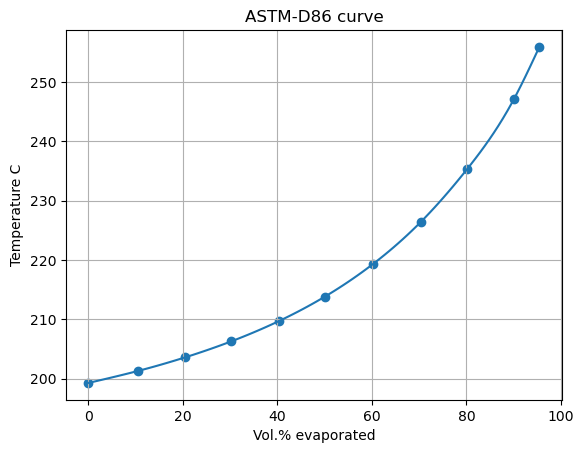

In [21]:
Temperature = np.array([samples[i]["T_flask"] for i in range(len(samples))])

vol_percent = np.array([(100 - samples[i]["volume_flask"]) for i in range(len(samples))])

c = CubicSpline(np.array(vol_percent), np.array(Temperature), mode=1)

targets = np.linspace(vol_percent[0] + 0.01, vol_percent[-1] - 0.01, 100)
temperature_2 = np.zeros(len(targets))
for i in range(len(targets)):
    temperature_2[i] = c.predict(targets[i])

plt.scatter(vol_percent, Temperature - 273.15)
plt.plot(targets, temperature_2 - 273.15)
plt.xlabel("Vol.% evaporated")
plt.ylabel("Temperature C")
plt.title("ASTM-D86 curve")
plt.grid()
plt.show()

### <span style="font-family: 'Times New Roman'; font-size: 20px; font-weight: bold;">Final Results</span>

In [22]:
ASTM_D86 = dict()
for sample in samples:
    ASTM_D86[100 - sample["volume_flask"]] = sample["T_flask"]

print("  Vol%   Temp. C")
print("-" * 20)
for key in ASTM_D86.keys():
    print(f"{key : 6.2f}% : {ASTM_D86[key] - 273.15: 6.2f}")
    
print("-" * 20)
print(f"Initial Boiling-Point: {ASTM_D86[list(ASTM_D86.keys())[0]] - 273.15 : 6.2f} C")
print(f"Final Boiling-Point:   {ASTM_D86[list(ASTM_D86.keys())[-1]] -273.15 : 6.2f} C")
print(f"Heat of Condeser: {Q_cond : 6.3f} kJ")

  Vol%   Temp. C
--------------------
  0.00% :  199.30
 10.40% :  201.30
 20.43% :  203.60
 30.22% :  206.30
 40.26% :  209.70
 49.96% :  213.80
 60.17% :  219.30
 70.31% :  226.40
 80.12% :  235.30
 90.11% :  247.20
 95.42% :  255.90
--------------------
Initial Boiling-Point:  199.30 C
Final Boiling-Point:    255.90 C
Heat of Condeser:  22.814 kJ
